# Vehicle Routing Problem for Omnichannel Retailing (FVRPOR)

This Jupyter Notebook implements and analyzes the Capacitated Vehicle Routing Problem for Omnichannel Retailing (FVRPOR) as described in the paper "Vehicle routing problem for omnichannel retailing including multiple types of time windows and products" by Ning Li and Zheng Wang (2025).

The model focuses on the first echelon of the distribution network and accounts for:
- Multiple product and online order types
- Hard and soft time windows
- Split delivery with integer quantities
- Vehicle capacity constraints

We use Gurobi as the Mixed-Integer Linear Program (MILP) solver to tackle this complex optimization problem.

## 1. Environment Setup & Library Imports

This section handles the initial setup, including importing all required Python libraries for modeling, solving (Gurobi), data manipulation, and visualization.

In [92]:
# Import Gurobi and other necessary libraries
import gurobipy as gp
from gurobipy import GRB
import random
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

# Optional: Print Gurobi version for reference
print(f"Gurobi Optimizer version: {gp.gurobi.version()}")

Gurobi Optimizer version: (12, 0, 2)


## 2. Helper Functions

This section contains general utility functions used by other parts of the notebook, such as calculating Euclidean distances between coordinates.

In [93]:
# Function to calculate Euclidean distance
def euclidean_distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

## 3. Instance Generation Function (`generate_instance_table2_final`)

This function is responsible for creating the problem data (parameters and sets) for an FVRPOR instance. Its design closely follows the definitions and derived sets as presented in Table 2 of the paper, along with the accompanying text.

**Key aspects covered by this function:**
-   **Node Definitions:** Central warehouse (depot), stores (`S`), and physical satellites (`M_phys`).
-   **Arc Generation:** All possible travel connections between defined nodes.
-   **Product and Order Types:** Categorization of goods (`R` for products, `B` for online orders).
-   **Geographic Coordinates:** Random generation of locations within a specified range.
-   **Travel Distances and Times:** Calculated based on Euclidean distance.
-   **Service Times:** Time spent at each customer node.
-   **Volume Parameters:** Defines the volume occupied by each product and order type.
-   **Demand Parameters:** Specifies the demand for each product type at stores and each order type at satellites.
-   **Time Window Deadlines:** Sets the `l_i` (delivery deadlines) for both stores (hard) and satellites (soft).
-   **Vehicle Fleet Size:** Calculated based on total demand volume and vehicle capacity, with an optional buffer.
-   **Big-M Value:** A large constant used in linearization constraints.

**Function Parameters (as per paper's context):**
-   `num_stores`: The number of physical stores (set `S`).
-   `num_physical_satellites`: The number of physical satellite locations (used to form `M \ {0}`).
-   `num_products`: The number of distinct product types (set `R`).
-   `num_orders`: The number of distinct online order types (set `B`).
-   `vehicle_capacity_V_star`: The volumetric capacity of each large vehicle (parameter `V*`).
-   `penalty_pu_param`: The unit penalty cost for delayed deliveries to satellites (parameter `P_u`).
-   `split_ps_param`: The extra cost incurred per split delivery (parameter `P_s`).
-   `seed`: A random seed to ensure reproducibility of generated instances.
-   `vehicle_buffer`: An integer buffer added to the minimum required number of vehicles (as per Eq. 1).

In [94]:
# --- Instance Generation Function (from your existing code) ---
# Paste the complete code for your `generate_instance_table2_final` function here.
# Make sure all internal variables and parameters align with the paper's notation.

def generate_instance_table2_final(num_stores, num_physical_satellites, num_products, num_orders,
                                   vehicle_capacity_V_star, penalty_pu_param, split_ps_param,
                                   seed=42, vehicle_buffer=0): # Default vehicle_buffer to 0, can be adjusted
    random.seed(seed)

    # --- SET DEFINITIONS (as per LaTeX derived from Table 2) ---
    depot_node_0 = 'D0' # Represents node '0'

    set_S_stores = [f"S{s_idx+1}" for s_idx in range(num_stores)]

    # M_T2 (Table 2's M): satellites where 0 denotes the central warehouse
    _physical_sat_nodes_temp = [f"M{m_idx+1}" for m_idx in range(num_physical_satellites)]
    set_M_T2_sats_and_depot = [depot_node_0] + _physical_sat_nodes_temp # This is M in Table 2

    # M_phys = M_T2 \ {0} : Physical satellite locations ONLY
    set_M_phys_physical_satellites = _physical_sat_nodes_temp

    # N_cust = S U M_phys : All CUSTOMER nodes (stores + physical satellites)
    set_N_cust_all_customers = set_S_stores + set_M_phys_physical_satellites

    # N_all = S U M_T2 : All NODES in network (stores + physical satellites + depot)
    set_N_all_network_nodes = list(set(set_S_stores + set_M_T2_sats_and_depot))

    # L_arcs: (i,j) in N_all x N_all, i != j
    set_L_arcs = [(i, j) for i in set_N_all_network_nodes for j in set_N_all_network_nodes if i != j]

    set_R_product_types = [f"P{r_idx+1}" for r_idx in range(num_products)]
    set_B_order_types = [f"B{b_idx+1}" for b_idx in range(num_orders)]

    # --- PARAMETERS ---
    param_coords = {depot_node_0: (0, 0)}
    for i_node in set_S_stores: param_coords[i_node] = (random.uniform(-25, 25), random.uniform(-25, 25)) # Smaller range
    for i_node in set_M_phys_physical_satellites: param_coords[i_node] = (random.uniform(-25, 25), random.uniform(-25, 25))

    param_d_ij_dist = {}; param_t_ij_time = {}; max_travel_t_val = 0
    for i_node, j_node in set_L_arcs:
        dist_val = euclidean_distance(param_coords[i_node], param_coords[j_node])
        param_d_ij_dist[i_node, j_node] = dist_val
        param_t_ij_time[i_node, j_node] = dist_val # Assuming speed = 1
        max_travel_t_val = max(max_travel_t_val, param_t_ij_time[i_node, j_node])
    for i_node in set_N_all_network_nodes : param_d_ij_dist[i_node,i_node]=0; param_t_ij_time[i_node,i_node]=0

    param_o_i_service = {node: 0 for node in set_N_all_network_nodes} # o_0 = 0 for depot
    total_serv_t_val = 0
    for node_cust in set_N_cust_all_customers:
        param_o_i_service[node_cust] = random.uniform(3, 10) # Smaller service times
        total_serv_t_val += param_o_i_service[node_cust]

    param_V_r_volume = {r_prod: random.randint(1, 3) for r_prod in set_R_product_types} # V_r
    param_V_b_volume = {b_ord: random.randint(1, 3) for b_ord in set_B_order_types} # V_b

    param_D_i_r_S_demand = {}; total_vol_demand_S = 0 # D_i^r (store i, product r)
    for j_store in set_S_stores:
        for r_prod in set_R_product_types:
            demand_val = random.randint(3, 10)
            param_D_i_r_S_demand[j_store, r_prod] = demand_val
            total_vol_demand_S += param_V_r_volume[r_prod] * demand_val

    param_D_i_b_Mphys_demand = {}; total_vol_demand_M_phys = 0 # D_i^b (satellite i, order b)
    for j_sat_phys in set_M_phys_physical_satellites:
        for b_ord in set_B_order_types:
            demand_val = random.randint(3, 10)
            param_D_i_b_Mphys_demand[j_sat_phys, b_ord] = demand_val
            total_vol_demand_M_phys += param_V_b_volume[b_ord] * demand_val

    total_overall_demand_vol = total_vol_demand_S + total_vol_demand_M_phys

    param_l_i_deadline = {} # l_i
    max_deadln_val = 0
    for node_cust in set_N_cust_all_customers:
        min_req_t = param_t_ij_time.get((depot_node_0, node_cust), float('inf')) + param_o_i_service.get(node_cust, 0)
        base_deadln_val = min_req_t + random.uniform(15, 50) # Tighter deadlines
        param_l_i_deadline[node_cust] = max(min_req_t + 0.1, base_deadln_val) # Ensure feasible by a small margin
        max_deadln_val = max(max_deadln_val, param_l_i_deadline[node_cust])
    param_l_i_deadline[depot_node_0] = max_deadln_val + max_travel_t_val + total_serv_t_val # Deadline for depot for Big-M

    # Fleet size VF based on Paper Eq. (1)
    numerator_eq1 = 0
    for r_prod in set_R_product_types:
        for j_store in set_S_stores:
            numerator_eq1 += param_V_r_volume[r_prod] * param_D_i_r_S_demand.get((j_store, r_prod), 0)
    for j_sat_phys in set_M_phys_physical_satellites:
        for b_ord in set_B_order_types:
            numerator_eq1 += param_V_b_volume[b_ord] * param_D_i_b_Mphys_demand.get((j_sat_phys, b_ord), 0)
    
    min_vehicles_eq1_val = 0
    if vehicle_capacity_V_star > 0:
        min_vehicles_eq1_val = math.ceil(numerator_eq1 / vehicle_capacity_V_star)
    else: # Fallback if V_star is 0 or negative
        min_vehicles_eq1_val = len(set_N_cust_all_customers) # Ensure at least one vehicle per customer if capacity is weird
        print(f"Warning: vehicle_capacity_V_star is {vehicle_capacity_V_star}. Using fallback for min_vehicles_eq1_val.")

    num_vehicles_in_fleet = int(min_vehicles_eq1_val + vehicle_buffer)
    set_VF_fleet = [f"K{k_idx+1}" for k_idx in range(num_vehicles_in_fleet)]

    param_M_TIME_for_big_M = param_l_i_deadline[depot_node_0] * 1.5 # Ensure it's large enough

    instance_data = {
        "S_stores": set_S_stores, "M_T2_sats_and_depot": set_M_T2_sats_and_depot,
        "M_phys_satellites": set_M_phys_physical_satellites, "N_cust_customers": set_N_cust_all_customers,
        "N_all_network_nodes": set_N_all_network_nodes, "L_arcs": set_L_arcs,
        "depot_node": depot_node_0, "R_product_types": set_R_product_types,
        "B_order_types": set_B_order_types, "VF_fleet": set_VF_fleet,
        "coords": param_coords, "d_ij": param_d_ij_dist, "t_ij": param_t_ij_time, # Renamed t_ij_travel to t_ij
        "o_i": param_o_i_service, "V_r": param_V_r_volume, # Renamed v_r_volume to V_r
        "V_b": param_V_b_volume, "D_i_r": param_D_i_r_S_demand, # Renamed D_jr_S_demand to D_i_r
        "D_i_b": param_D_i_b_Mphys_demand, "l_i": param_l_i_deadline, # Renamed l_j_deadline to l_i
        "V_star": vehicle_capacity_V_star, "p_u": penalty_pu_param, # Renamed
        "p_s": split_ps_param, "M_TIME_BIG": param_M_TIME_for_big_M, # Renamed
        "total_demand_vol_overall": total_overall_demand_vol, "min_vehicles_eq1": min_vehicles_eq1_val,
        "vehicle_buffer": vehicle_buffer # Store buffer for sensitivity
    }
    return instance_data

## 4. FVRPOR Model Building & Solving Function (`solve_vrpor_table2_final`)

This function constructs the Mixed-Integer Non-Linear Program (MINLP) model for the FVRPOR using Gurobi's Python API, and then invokes the solver. The model formulation strictly adheres to the equations (Eq. 2 through Eq. 16) as presented in the paper.

**Objective Function (Eq. 2) Components:**
-   **Travel Cost:** Minimizes the total distance covered by all vehicles.
-   **Soft Time Window Penalty:** Incurs costs for deliveries to satellites that exceed their specified deadlines. This penalty term is bi-linear (`P_u * (t_jk - l_j)^+ * (\sum V_b Y_jkb)`), which necessitates setting `model.Params.NonConvex = 2` in Gurobi to allow it to solve non-convex quadratic terms.
-   **Split Delivery Cost:** An additional cost (`P_s`) is applied for each instance where a store or satellite is visited by more than one vehicle (i.e., its demand is split).

**Constraints (Eqs. 3-16):**
-   **Routing Constraints (Eqs. 3-6):** Ensure valid vehicle routes, including starting and ending at the depot, flow conservation at customer nodes, and ensuring each customer node is visited at most once *per vehicle*.
-   **Capacity Constraints (Eqs. 7-9):** Restrict the total volume of products and online orders carried by each vehicle within `V*`.
    -   Eq. 7 & 8 also link the quantity of products/orders delivered by vehicle `k` to node `j` to whether vehicle `k` actually visits node `j`.
-   **Demand Satisfaction Constraints (Eqs. 10-11):** Guarantee that the total demand for all product types at stores and all online order types at satellites are fully satisfied across all visiting vehicles.
-   **Time Constraints (Eqs. 12-13):**
    -   **Eq. 12 (Time Progression):** Propagates arrival times through the route, accounting for travel time and service time at each node.
    -   **Eq. 13 (Hard Time Window for Stores):** Enforces that vehicle arrival times at store nodes (`j \in S`) must be within their hard time window deadlines (`l_j`). The Big-M term ensures this applies only if the node is visited.
-   **Variable Type Constraints (Eqs. 14-16):** Define `x` as binary, and `Q`, `Y` as non-negative integers. The integer requirement for `Q` and `Y` is critical for practical split delivery, ensuring that individual products/orders are not fractional.

**Gurobi Specific Parameters:**
-   `TimeLimit`: Sets the maximum time Gurobi can spend on solving the model.
-   `MIPGap`: Defines the acceptable gap between the best incumbent solution and the best possible lower bound (for non-optimal solutions).
-   `NonConvex = 2`: Crucial for handling the non-convex bilinear terms in the objective function. This tells Gurobi to attempt to find a global optimum for non-convex quadratic problems.
-   `LogToConsole`: Controls whether Gurobi's solving progress is printed to the console.

In [95]:
def solve_vrpor_table2_final(instance, time_limit=60, mip_gap=0.001, log_to_console=0):
    S = instance["S_stores"]; M_T2 = instance["M_T2_sats_and_depot"]; M_phys = instance["M_phys_satellites"]
    N_cust = instance["N_cust_customers"]; N_all = instance["N_all_network_nodes"]
    L_arcs_set = instance["L_arcs"]; depot = instance["depot_node"]
    R_set = instance["R_product_types"]; B_set = instance["B_order_types"]; VF_set = instance["VF_fleet"]
    d_ij = instance["d_ij"]; t_ij = instance["t_ij"]; o_i = instance["o_i"]
    V_r = instance["V_r"]; V_b = instance["V_b"]; D_i_r = instance["D_i_r"] # Demands for stores
    D_i_b = instance["D_i_b"]; l_i = instance["l_i"]; V_star = instance["V_star"] # Demands for satellites
    p_u = instance["p_u"]; p_s = instance["p_s"]; M_BIG = instance["M_TIME_BIG"]

    model = gp.Model("VRPOR_Table2_StrictFinal_Improved")
    model.Params.LogToConsole = log_to_console
    model.Params.TimeLimit = time_limit; model.Params.MIPGap = mip_gap; model.Params.NonConvex = 2

    # --- Decision Variables (as per LaTeX Table 2) ---
    x = model.addVars(L_arcs_set, VF_set, vtype=GRB.BINARY, name="x") # x_ij^k
    Q = model.addVars(S, VF_set, R_set, vtype=GRB.INTEGER, lb=0.0, name="Q") # Q_j^kr (j in S)
    Y = model.addVars(M_phys, VF_set, B_set, vtype=GRB.INTEGER, lb=0.0, name="Y") # Y_j^kb (j in M_phys)
    t_arrival = model.addVars(N_all, VF_set, vtype=GRB.CONTINUOUS, lb=0.0, name="t_k_j") # t_j^k (all nodes for consistency with Eq12)

    # --- Auxiliary Variables for Objective ---
    # For (t_j^k - l_j)^+ part of penalty term
    t_minus_l_positive = model.addVars(M_phys, VF_set, vtype=GRB.CONTINUOUS, lb=0.0, name="t_minus_l_pos")
    # For sum_{b in B} V_b Y_j^kb part of penalty term
    volume_Y_jk = model.addVars(M_phys, VF_set, vtype=GRB.CONTINUOUS, lb=0.0, name="vol_Y_jk")
    # For ((sum_k sum_i x_ij^k) - 1)^+ part of split cost
    total_arrivals_at_j = model.addVars(N_cust, vtype=GRB.INTEGER, lb=0.0, name="total_arrivals_j")
    extra_arrivals_at_j_positive = model.addVars(N_cust, vtype=GRB.CONTINUOUS, lb=0.0, name="extra_arrivals_j_pos")
    
    zero_var = model.addVar(lb=0.0, ub=0.0, name="zero_constant_for_max") # Helper for max(A,0)

    # --- Objective Function (Eq. 2 from LaTeX) ---
    term1_travel_cost = gp.quicksum(d_ij[i_node,j_node] * x[i_node,j_node,k_veh]
                                   for (i_node,j_node) in L_arcs_set for k_veh in VF_set)
    
    # Define auxiliary variables for bi-linear term
    for j_sat in M_phys:
        for k_veh in VF_set:
            model.addConstr(t_minus_l_positive[j_sat, k_veh] >= t_arrival[j_sat, k_veh] - l_i[j_sat], name=f"def_t_minus_l_pos_{j_sat}_{k_veh}")
            model.addConstr(volume_Y_jk[j_sat, k_veh] == gp.quicksum(V_b[b_ord] * Y[j_sat, k_veh, b_ord]
                                                                    for b_ord in B_set if (j_sat,k_veh,b_ord) in Y), name=f"def_vol_Y_{j_sat}_{k_veh}")
    term2_penalty_cost = gp.quicksum(p_u * t_minus_l_positive[j_sat, k_veh] * volume_Y_jk[j_sat, k_veh]
                                      for j_sat in M_phys for k_veh in VF_set)

    # Define auxiliary variables for split cost term
    for j_node_cust in N_cust:
        model.addConstr(total_arrivals_at_j[j_node_cust] == gp.quicksum(x[i_node, j_node_cust, k_veh]
                                                                    for (i_node, _j) in L_arcs_set if _j == j_node_cust # Sum over i for fixed j
                                                                    for k_veh in VF_set), name=f"def_total_arrivals_{j_node_cust}")
        # (A - 1)+ = max(A-1, 0)
        model.addConstr(extra_arrivals_at_j_positive[j_node_cust] >= total_arrivals_at_j[j_node_cust] - 1, name=f"def_extra_arr_ge_m1_{j_node_cust}")
        model.addConstr(extra_arrivals_at_j_positive[j_node_cust] >= zero_var, name=f"def_extra_arr_ge_0_{j_node_cust}") # Ensures positive for max
        # Gurobi's max_ function can also be used if preferred: model.addConstr(extra_arrivals_at_j_positive[j_node_cust] == gp.max_(total_arrivals_at_j[j_node_cust] - 1, zero_var), name=f"def_extra_arrivals_max_{j_node_cust}")

    term3_split_cost = p_s * gp.quicksum(extra_arrivals_at_j_positive[j_node_cust] for j_node_cust in N_cust)

    model.setObjective(term1_travel_cost + term2_penalty_cost + term3_split_cost, GRB.MINIMIZE)

    # --- Constraints (Eqs. 3-16 from LaTeX) ---
    # Eq. 3
    model.addConstr(gp.quicksum(x[depot,j_node_cust,k_veh] for j_node_cust in N_cust if (depot,j_node_cust) in L_arcs_set for k_veh in VF_set) <= len(VF_set), "PaperEq3_TotalDepartures")

    # Eq. 4
    for k_veh in VF_set:
        sum_out_depot = gp.quicksum(x[depot,j_node_cust,k_veh] for j_node_cust in N_cust if (depot,j_node_cust) in L_arcs_set)
        sum_in_depot  = gp.quicksum(x[i_node_cust,depot,k_veh] for i_node_cust in N_cust if (i_node_cust,depot) in L_arcs_set)
        model.addConstr(sum_out_depot == sum_in_depot, f"PaperEq4_ReturnToDepot_{k_veh}")
        model.addConstr(sum_out_depot <= 1, f"PaperEq4_DepartDepotOnce_{k_veh}")

    # Eq. 5
    for k_veh in VF_set:
        for j_node_cust in N_cust:
            model.addConstr(gp.quicksum(x[i_node,j_node_cust,k_veh] for i_node in N_all if (i_node,j_node_cust) in L_arcs_set and i_node != j_node_cust) <= 1, f"PaperEq5_VisitCustOncePerVeh_{k_veh}_{j_node_cust}")

    # Eq. 6
    for k_veh in VF_set:
        for j_node_cust in N_cust:
            inflow_j = gp.quicksum(x[i_node,j_node_cust,k_veh] for i_node in N_all if (i_node,j_node_cust) in L_arcs_set and i_node != j_node_cust)
            outflow_j = gp.quicksum(x[j_node_cust,l_node,k_veh] for l_node in N_all if (j_node_cust,l_node) in L_arcs_set and l_node != j_node_cust)
            model.addConstr(inflow_j - outflow_j == 0, f"PaperEq6_FlowConservation_{k_veh}_{j_node_cust}")

    # Eq. 7
    for j_store in S:
        for k_veh in VF_set:
            vehicle_visits_j = gp.quicksum(x[i_node, j_store, k_veh] for i_node in N_all if (i_node, j_store) in L_arcs_set and i_node != j_store)
            for r_prod in R_set:
                if (j_store, r_prod) in D_i_r: # Check if demand exists
                     model.addConstr(Q[j_store, k_veh, r_prod] <= D_i_r[j_store, r_prod] * vehicle_visits_j, f"PaperEq7_LinkQtoX_{j_store}_{k_veh}_{r_prod}")

    # Eq. 8
    for j_sat in M_phys:
        for k_veh in VF_set:
            vehicle_visits_j = gp.quicksum(x[i_node, j_sat, k_veh] for i_node in N_all if (i_node, j_sat) in L_arcs_set and i_node != j_sat)
            for b_ord in B_set:
                 if (j_sat, b_ord) in D_i_b: # Check if demand exists
                    model.addConstr(Y[j_sat, k_veh, b_ord] <= D_i_b[j_sat, b_ord] * vehicle_visits_j, f"PaperEq8_LinkYtoX_{j_sat}_{k_veh}_{b_ord}")

    # Eq. 9
    for k_veh in VF_set:
        volume_products_Q = gp.quicksum(V_r[r_prod] * Q[j_store,k_veh,r_prod] for j_store in S for r_prod in R_set if (j_store,k_veh,r_prod) in Q)
        volume_orders_Y = gp.quicksum(V_b[b_ord] * Y[j_sat,k_veh,b_ord] for j_sat in M_phys for b_ord in B_set if (j_sat,k_veh,b_ord) in Y)
        model.addConstr(volume_products_Q + volume_orders_Y <= V_star, f"PaperEq9_VehicleCapacity_{k_veh}")

    # Eq. 10
    for j_store in S:
        for r_prod in R_set:
            if (j_store, r_prod) in D_i_r: # Check if demand exists
                model.addConstr(gp.quicksum(Q[j_store,k_veh,r_prod] for k_veh in VF_set if (j_store,k_veh,r_prod) in Q) == D_i_r[j_store,r_prod], f"PaperEq10_DemandSat_S_{j_store}_{r_prod}")

    # Eq. 11
    for j_sat in M_phys:
        for b_ord in B_set:
             if (j_sat, b_ord) in D_i_b: # Check if demand exists
                model.addConstr(gp.quicksum(Y[j_sat,k_veh,b_ord] for k_veh in VF_set if (j_sat,k_veh,b_ord) in Y) == D_i_b[j_sat,b_ord], f"PaperEq11_DemandSat_Mphys_{j_sat}_{b_ord}")

    # Eq. 12 (Time propagation with Big-M)
    model.addConstrs((t_arrival[depot,k_veh] == 0 for k_veh in VF_set), name="TimeAtDepotIsZero_Eq12_base")
    for k_veh in VF_set:
        for j_node_cust in N_cust: # For j in S U M/{0}
            for i_node in N_all: # Sum over i in N_all (S U M in paper)
                if (i_node,j_node_cust) in L_arcs_set and i_node != j_node_cust :
                     # t_j^k >= t_i^k + o_i + t_ij - M(1-x_ij^k)
                    model.addConstr(t_arrival[j_node_cust,k_veh] >= t_arrival[i_node,k_veh] + o_i.get(i_node,0) + t_ij.get((i_node,j_node_cust),0) - M_BIG*(1-x[i_node,j_node_cust,k_veh]), f"PaperEq12_TimeProp_{k_veh}_{i_node}_{j_node_cust}")

    # Eq. 13 (Hard time window for stores S with Big-M)
    for k_veh in VF_set:
        for j_store in S:
            # t_j^k <= l_j + M(1 - sum_i x_ij^k)
            # sum_i x_ij^k is 1 if store j is visited by vehicle k, 0 otherwise.
            is_visited_by_k = gp.quicksum(x[i_node,j_store,k_veh] for i_node in N_all if (i_node,j_store) in L_arcs_set and i_node != j_store)
            model.addConstr(t_arrival[j_store,k_veh] <= l_i[j_store] + M_BIG*(1-is_visited_by_k), f"PaperEq13_HardTW_S_{k_veh}_{j_store}")
    
    # Eq. 14 (x binary), Eq. 15 (Y integer), Eq. 16 (Q integer) are handled by var definitions.

    # Symmetry Breaking (optional, but can help)
    for k_idx in range(len(VF_set)-1):
        k_curr, k_next = VF_set[k_idx], VF_set[k_idx+1]
        # Force earlier vehicles to be used before later ones
        sum_departs_curr = gp.quicksum(x[depot, jc, k_curr] for jc in N_cust if (depot, jc) in L_arcs_set)
        sum_departs_next = gp.quicksum(x[depot, jc, k_next] for jc in N_cust if (depot, jc) in L_arcs_set)
        model.addConstr(sum_departs_next <= sum_departs_curr, f"SymmetryBreaking_VehOrder_{k_curr}_{k_next}")


    start_time=time.time();model.optimize();end_time=time.time();solve_duration=end_time-start_time
    results={"instance":instance,"model":model,"status_code":model.status,"solve_time":solve_duration,"status_message":{GRB.OPTIMAL:"Optimal",GRB.TIME_LIMIT:"Time Limit Reached",GRB.INTERRUPTED:"Interrupted",GRB.INFEASIBLE:"Infeasible",GRB.UNBOUNDED:"Unbounded",GRB.INF_OR_UNBD:"Infeasible or Unbounded"}.get(model.status,f"Unknown Status ({model.status})")}
    if model.status in [GRB.OPTIMAL,GRB.TIME_LIMIT,GRB.INTERRUPTED] and model.SolCount>0:
        results.update({"objective_value":model.ObjVal,"runtime":model.Runtime,"mip_gap":model.MIPGap,"node_count":model.NodeCount})
        
        sol_x_val={ k_sol_tuple : k_sol_var.X for k_sol_tuple,k_sol_var in x.items() if k_sol_var.X > 0.5 }
        sol_Q_val={k_sol:v.X for k_sol,v in Q.items() if v.X>0.5}
        sol_Y_val={k_sol:v.X for k_sol,v in Y.items() if v.X>0.5}
        sol_t_val={k_sol:v.X for k_sol,v in t_arrival.items()} # Get all arrival times
        
        sol_late_plus_val = {}
        if hasattr(t_minus_l_positive, 'items'): # Check if var was added (e.g. if M_phys is not empty)
            sol_late_plus_val={k_s:v.X for k_s,v in t_minus_l_positive.items() if v.X > 1e-6}
        
        sol_extra_arrivals_val = {}
        if hasattr(extra_arrivals_at_j_positive, 'items'):
             sol_extra_arrivals_val={k_s:v.X for k_s,v in extra_arrivals_at_j_positive.items() if v.X > 0.5} # Should be integer-like

        sol_volY_kj_val = {}
        if hasattr(volume_Y_jk, 'items'):
            sol_volY_kj_val={k_s:v.X for k_s,v in volume_Y_jk.items() if v.X > 1e-4}

        results["solution"]={"x":sol_x_val,"Q":sol_Q_val,"Y":sol_Y_val,"t_arrival":sol_t_val,
                             "lateness_positive_part":sol_late_plus_val,
                             "split_extra_visits_image":sol_extra_arrivals_val,
                             "total_volume_Y_jk_for_penalty":sol_volY_kj_val}


        obj_T_calc=sum(d_ij[i,j]*x_val for (i,j,k),x_val in sol_x_val.items() if (i,j) in d_ij)
        obj_P_calc=sum(p_u*sol_late_plus_val.get((jm,kv),0)*sol_volY_kj_val.get((jm,kv),0) for jm in M_phys for kv in VF_set)
        obj_S_calc=sum(p_s*val for jc,val in sol_extra_arrivals_val.items())
        results["objective_components"]={"travel":obj_T_calc,"penalty":obj_P_calc,"split":obj_S_calc,"calculated_total":obj_T_calc+obj_P_calc+obj_S_calc}

        routes_found={}; cust_served_set=set()
        for k_v_rt in VF_set:
            departs_d = any(sol_x_val.get(((depot,jc,k_v_rt)),0)>0.5 for jc in N_cust if (depot,jc) in L_arcs_set)
            if departs_d:
                rt_k_list=[depot];curr_node_rt=depot;visited_nodes_rt={depot}
                for _ in range(len(N_all)+2): # Max possible nodes + depot return
                    next_node_sel=None
                    # Iterate through L_arcs_set to find outgoing arc for current_node_rt
                    for i_arc_rt, j_arc_rt in L_arcs_set:
                        if i_arc_rt == curr_node_rt and sol_x_val.get(((i_arc_rt,j_arc_rt,k_v_rt)),0)>0.5:
                            # Prefer non-visited node, or depot if it's the only option to close loop
                            if j_arc_rt not in visited_nodes_rt or (j_arc_rt == depot and len(rt_k_list) > 1):
                                next_node_sel=j_arc_rt; break
                    if not next_node_sel: # Could be end of path not at depot, or only visited nodes left
                        if curr_node_rt != depot and (curr_node_rt, depot) in L_arcs_set and sol_x_val.get(((curr_node_rt,depot,k_v_rt)),0)>0.5:
                             if depot not in visited_nodes_rt or len(rt_k_list) > 1 : # Allow returning to depot
                                rt_k_list.append(depot)
                        break
                    rt_k_list.append(next_node_sel)
                    if next_node_sel != depot : visited_nodes_rt.add(next_node_sel) # Don't mark depot as "visited" to allow return
                    if next_node_sel in N_cust:cust_served_set.add(next_node_sel)
                    curr_node_rt=next_node_sel
                    if curr_node_rt==depot and len(rt_k_list)>1 :break # Route ended at depot
                
                # Refined route validation
                if len(rt_k_list)>2 and rt_k_list[0]==depot and rt_k_list[-1]==depot:
                    routes_found[k_v_rt]=rt_k_list
                elif len(rt_k_list)>1 and rt_k_list[0]==depot: # Started from depot but might not have returned
                    # Attempt to add depot if it's the only logical next step
                    final_node = rt_k_list[-1]
                    if final_node != depot and (final_node, depot) in L_arcs_set and sol_x_val.get(((final_node, depot, k_v_rt)), 0) > 0.5:
                        rt_k_list.append(depot)
                        if rt_k_list[0] == depot and rt_k_list[-1] == depot:
                             routes_found[k_v_rt]=rt_k_list
                        else: print(f"Warning: Route {k_v_rt} seems incomplete after trying to close: {rt_k_list}")
                    elif final_node != depot:
                        print(f"Warning: Route {k_v_rt} is incomplete or open: {rt_k_list}")


        results["routes"]=routes_found;results["nodes_served"]=len(cust_served_set)
    else:results.update({"objective_value":None,"runtime":model.Runtime,"mip_gap":None,"node_count":model.NodeCount if hasattr(model,'NodeCount') else None,"solution":None,"routes":None,"nodes_served":0,"objective_components":None})
    return results

## 5. Results Display & Plotting Functions

These functions assist in presenting the optimization results in an understandable manner, both textually and visually.

In [96]:
def print_results_summary(results):
    print("\n--- Optimization Summary ---")
    print(f"Status: {results.get('status_message', 'N/A')} (Code: {results.get('status_code', 'N/A')})")
    obj_val = results.get("objective_value")
    if obj_val is not None:
        print(f"Objective Value: {obj_val:.2f}")
        obj_comp = results.get("objective_components")
        if obj_comp: print(f"  Components: Travel={obj_comp['travel']:.2f}, Penalty={obj_comp['penalty']:.2f}, Split={obj_comp['split']:.2f} (Calc Sum: {obj_comp['calculated_total']:.2f})")
        else: print("  Objective components not calculated.")
        print(f"Gurobi Runtime: {results.get('runtime',0):.2f}s / Wall Clock: {results.get('solve_time',0):.2f}s")
        print(f"MIP Gap: {results.get('mip_gap','N/A'):.4f}" if results.get('mip_gap') is not None else "MIP Gap: N/A")
        print(f"Nodes Explored: {results.get('node_count','N/A')}")
        print(f"Nodes Served: {results.get('nodes_served','N/A')} / {len(results['instance']['N_cust_customers'])}")
        routes = results.get("routes"); sol = results.get("solution")
        t_val = sol.get("t_arrival")
        y_val = sol.get("total_volume_Y_jk_for_penalty")
        if routes: print(f"\nRoutes Found ({len(routes)}):"); [print(f"  {k}: {' -> '.join(route)}") for k,route in routes.items()]
        else: print("\nNo valid routes extracted.")
        if sol:
             split_visits_img = sol.get("split_extra_visits_image")
             lateness_pos_part_vals = sol.get("lateness_positive_part")
             if split_visits_img and any(v > 0.5 for v in split_visits_img.values()): print("\nSplit Deliveries (Extra Visits > 0):"); [print(f"  Node {j}: {int(round(extra))} extra visit(s)") for j, extra in split_visits_img.items() if extra > 0.5]
             if y_val and any(v > 0 for v in y_val.values()):
                for jk, val in lateness_pos_part_vals.items():
                    for jk2, val2 in y_val.items():
                        if jk== jk2:
                            if val2 > 1e-4 and val > 1e-4: print("\nLate Deliveries at Satellites (Lateness > 0):"); print(f"  Node {jk[0]} by Veh {jk[1]}: {val:.2f} time units late")
                #if lateness_pos_part_vals and any(v > 1e-4 for v in lateness_pos_part_vals.values()): print("\nLate Deliveries at Satellites (Lateness > 0):"); [print(f"  Node {jk[0]} by Veh {jk[1]}: {val:.2f} time units late") for jk, val in lateness_pos_part_vals.items() if val > 1e-4]
    else:
        print("No feasible solution found or optimization failed."); print(f"Gurobi Runtime: {results.get('runtime',0):.2f}s / Wall Clock: {results.get('solve_time',0):.2f}s"); print(f"Nodes Explored: {results.get('node_count','N/A')}")
    print("--------------------------\n")

def plot_solution_routes(results):
    instance = results.get("instance"); routes = results.get("routes")
    if not instance or not routes: print("Cannot plot: Missing instance or routes."); return
    coords = instance["coords"]; depot = instance["depot_node"]
    S_nodes = instance["S_stores"]; M_nodes = instance["M_phys_satellites"] # Correct key
    plt.figure(figsize=(12,10)); plt.scatter(coords[depot][0], coords[depot][1], c='black', marker='s', s=150, label=f'Depot ({depot})', zorder=5)
    if S_nodes: plt.scatter(*zip(*[coords[s] for s in S_nodes if s in coords]), c='blue', marker='o', s=80, label='Stores (S)', zorder=5)
    if M_nodes: plt.scatter(*zip(*[coords[m] for m in M_nodes if m in coords]), c='red', marker='^', s=80, label='Satellites (M_phys)', zorder=5) # Correct label
    for node,(x_coord,y_coord) in coords.items(): plt.text(x_coord, y_coord+0.8, node, fontsize=9, ha='center') # Adjusted offset
    num_r = len(routes); colors = plt.cm.viridis(np.linspace(0,1,max(1,num_r))) if num_r >0 else ['gray']
    veh_idx = 0
    for k,route in routes.items():
        route_coords_list = []
        for node_in_route in route:
            if node_in_route in coords: route_coords_list.append(coords[node_in_route])
            else: print(f"Warning: Node {node_in_route} in route for vehicle {k} not in coords dict."); return
        if not route_coords_list: continue
        route_coords_arr = np.array(route_coords_list)
        plt.plot(route_coords_arr[:,0], route_coords_arr[:,1], linestyle='-', marker='.', color=colors[min(veh_idx, len(colors)-1)], label=f'Veh {k}', lw=1.5, ms=5)
        veh_idx+=1
    plt.xlabel("X-coord"); plt.ylabel("Y-coord"); plt.title("Vehicle Routes"); plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=min(5,num_r+3)); plt.grid(True,ls='--',alpha=0.6); plt.axis('equal'); plt.tight_layout(rect=[0,0.05,1,1]); plt.show()

def plot_cost_breakdown(results):
    obj_comp = results.get("objective_components"); obj_val = results.get("objective_value")
    if not obj_comp or obj_val is None or obj_val <=1e-6 : print("Cannot plot cost: Missing components or zero/neg objective."); return
    labels = ['Travel','Penalty (Lateness)','Split Cost']; sizes = [obj_comp.get('travel',0), obj_comp.get('penalty',0), obj_comp.get('split',0)]
    labels_f = [l for i,l in enumerate(labels) if sizes[i]>1e-6]; sizes_f = [s for s in sizes if s>1e-6]
    if not sizes_f: print("Cost breakdown: All components are zero/negligible."); return
    fig,ax = plt.subplots(figsize=(7,7)); ax.pie(sizes_f, labels=labels_f, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
    ax.axis('equal'); plt.title(f'Objective Cost Breakdown (Total: {obj_val:.2f})'); centre_circle=plt.Circle((0,0),0.70,fc='white'); fig.gca().add_artist(centre_circle); plt.tight_layout(); plt.show()

## 6. Execution & Analysis

In this section, we execute the model on various instances to evaluate its performance and gain insights.

### 6.1 Verification Instance Setup & Run

A very simple instance is created and solved here. We will manually check its results against expected values.

In [97]:
# --- Verification Instance Setup ---
print("--- Verification Instance Generation & Setup (Strict Table 2 Alignment) ---")
verify_params_final = {"num_stores":1,"num_physical_satellites":1,"num_products":1,"num_orders":1,
                       "vehicle_capacity_V_star":100,"penalty_pu_param":10.0,"split_ps_param":1000.0,
                       "seed":1, "vehicle_buffer":1} # Buffer 1 ensures at least 2 vehicles if Eq1 is 1.
verify_instance_final = generate_instance_table2_final(**verify_params_final)
print(f"Verification: Min vehicles by Eq1: {verify_instance_final['min_vehicles_eq1']}, Actual |VF|: {len(verify_instance_final['VF_fleet'])}")

s_v = verify_instance_final["S_stores"][0]; m_v = verify_instance_final["M_phys_satellites"][0]
p_v = verify_instance_final["R_product_types"][0]; o_v = verify_instance_final["B_order_types"][0]
d_v_depot = verify_instance_final["depot_node"] # Corrected key
verify_instance_final["D_i_r"] = {(s_v,p_v):10}; verify_instance_final["D_i_b"] = {(m_v,o_v):8}
verify_instance_final["V_r"] = {p_v:5}; verify_instance_final["V_b"] = {o_v:6}
verify_instance_final["coords"][s_v]=(3,4); verify_instance_final["coords"][m_v]=(-6,8)
verify_instance_final["o_i"][s_v]=2; verify_instance_final["o_i"][m_v]=3
verify_instance_final["l_i"][s_v]=15; verify_instance_final["l_i"][m_v]=30

nodes_v_all = verify_instance_final["N_all_network_nodes"]; d_v_new={}; t_v_new={}
for i_n_v in nodes_v_all:
    for j_n_v in nodes_v_all:
        d_val=euclidean_distance(verify_instance_final["coords"][i_n_v],verify_instance_final["coords"][j_n_v]) if i_n_v!=j_n_v else 0
        d_v_new[i_n_v,j_n_v]=d_val; t_v_new[i_n_v,j_n_v]=d_val
verify_instance_final["d_ij"]=d_v_new; verify_instance_final["t_ij"]=t_v_new
verify_instance_final["M_TIME_BIG"]= sum(t_v_new.values()) + sum(verify_instance_final["o_i"].values()) + 100 # More robust M_TIME_BIG
verify_instance_final["L_arcs"] = [(i, j) for i in verify_instance_final["N_all_network_nodes"] for j in verify_instance_final["N_all_network_nodes"] if i != j]
print("Verification instance setup complete.")

--- Verification Instance Generation & Setup (Strict Table 2 Alignment) ---
Verification: Min vehicles by Eq1: 1, Actual |VF|: 2
Verification instance setup complete.


### 6.2 Basic Instance Run

This section runs the model on a moderately sized instance, allowing us to observe its general performance.

--- Basic Run: Generating Larger & More Complex Instance (Strict Table 2 Alignment) ---
Instance: 1S, 1M_phys (2 cust). Demand Vol: 124.00. Fleet: 4 (Cap: 60). Eq1 Min Veh: 3

--- Running Basic Instance (Strict Table 2 Alignment, Targeting ~75s) ---
Set parameter LogToConsole to value 1
Set parameter TimeLimit to value 90
Set parameter MIPGap to value 0.01
Set parameter NonConvex to value 2
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  90
MIPGap  0.01
NonConvex  2

Optimize a model with 120 rows, 89 columns and 414 nonzeros
Model fingerprint: 0xa0e46007
Model has 4 quadratic objective terms
Variable types: 23 continuous, 66 integer (24 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [5e+00, 3e+01]
  QObjective range 

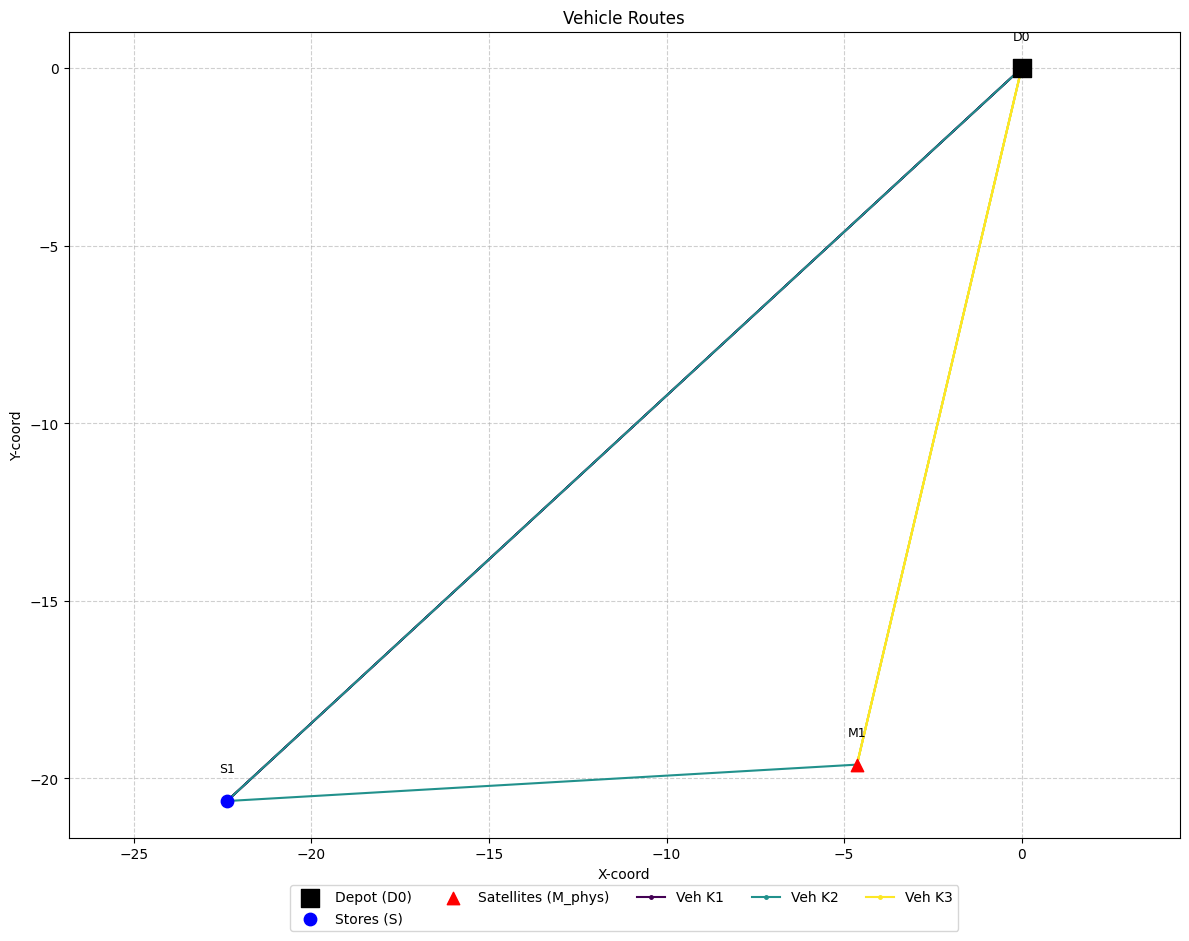

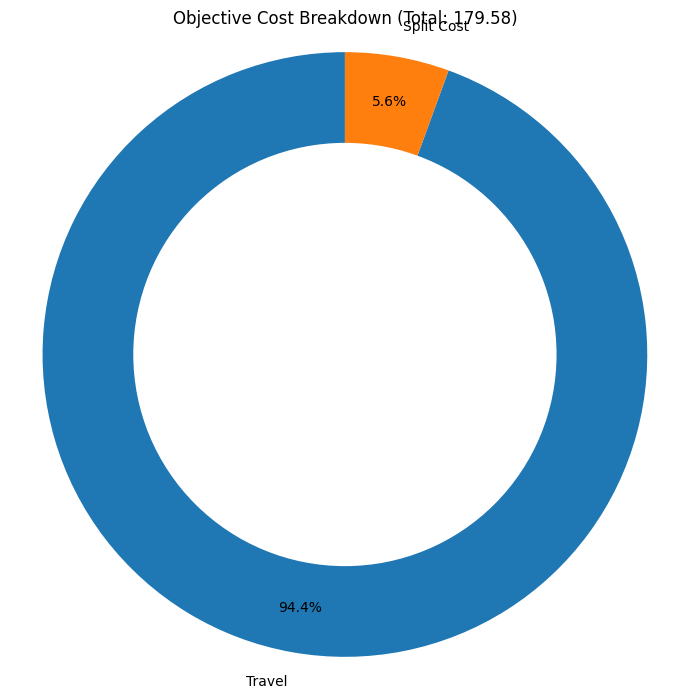

In [98]:
# --- Basic Run with LARGER, MORE COMPLEX Instance ---
print("--- Basic Run: Generating Larger & More Complex Instance (Strict Table 2 Alignment) ---")
basic_params_final = {"num_stores":1, "num_physical_satellites":1, "num_products":5, "num_orders":5,
                       "vehicle_capacity_V_star":60, "penalty_pu_param":0.5, "split_ps_param":5.0,
                       "seed":123, "vehicle_buffer": 1}
basic_instance_final = generate_instance_table2_final(**basic_params_final)
print(f"Instance: {len(basic_instance_final['S_stores'])}S, {len(basic_instance_final['M_phys_satellites'])}M_phys ({len(basic_instance_final['N_cust_customers'])} cust). Demand Vol: {basic_instance_final['total_demand_vol_overall']:.2f}. Fleet: {len(basic_instance_final['VF_fleet'])} (Cap: {basic_instance_final['V_star']}). Eq1 Min Veh: {basic_instance_final['min_vehicles_eq1']}")

print("\n--- Running Basic Instance (Strict Table 2 Alignment, Targeting ~75s) ---")
basic_results_final = solve_vrpor_table2_final(basic_instance_final, time_limit=90, mip_gap=0.01, log_to_console=1)
print_results_summary(basic_results_final)

print("\n--- Visualizing Basic Run Results (Strict Table 2 Alignment) ---")
if basic_results_final.get("routes"): plot_solution_routes(basic_results_final)
if basic_results_final.get("objective_components"): plot_cost_breakdown(basic_results_final)